# 论文22：神经语言模型的扩展定律
## Jared Kaplan et al. (2020)

### 可预测的扩展：损失作为计算、数据和参数的函数

经验分析展示了神经网络扩展中的幂律关系。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 扩展定律公式 (Scaling Law Formulation)

关键发现：损失遵循幂律：
$$L(N) = \left(\frac{N_c}{N}\right)^{\alpha_N}$$

其中：
- N = 参数数量
- D = 数据集大小
- C = 计算预算（FLOPs）

In [2]:
def power_law(x, a, b, c):
    """Power law: y = a * x^(-b) + c"""
    return a * np.power(x, -b) + c

def scaling_law_params(x, a, b):
    """Simplified: L = a * N^(-b)"""
    return a * np.power(x, -b)

# Theoretical scaling law constants (from paper)
# These are approximate values from Kaplan et al.
alpha_N = 0.076  # Parameters scaling exponent
alpha_D = 0.095  # Data scaling exponent  
alpha_C = 0.050  # Compute scaling exponent

N_c = 8.8e13     # Critical parameter count
D_c = 5.4e13     # Critical dataset size
C_c = 3.1e8      # Critical compute

print("Scaling Law Parameters (from paper):")
print(f"  α_N (params): {alpha_N}")
print(f"  α_D (data): {alpha_D}")
print(f"  α_C (compute): {alpha_C}")

Scaling Law Parameters (from paper):
  α_N (params): 0.076
  α_D (data): 0.095
  α_C (compute): 0.05


## 在不同规模下模拟模型训练 (Simulate Model Training at Different Scales)

In [3]:
class SimpleLanguageModel:
    """
    Toy language model to demonstrate scaling behavior
    """
    def __init__(self, num_params, vocab_size=100, embed_dim=32):
        self.num_params = num_params
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        
        # Calculate capacity from parameter count
        self.capacity = np.log(num_params) / 10.0
    
    def train(self, dataset_size, num_steps):
        """
        Simulate training and return final loss
        
        Loss decreases with:
        - More parameters (more capacity)
        - More data (better learning)
        - More training (convergence)
        """
        # Base loss (vocabulary perplexity)
        base_loss = np.log(self.vocab_size)
        
        # Parameter scaling (more params = lower loss)
        param_factor = 1.0 / (1.0 + self.capacity)
        
        # Data scaling (more data = lower loss)
        data_factor = 1.0 / (1.0 + np.log(dataset_size) / 15.0)
        
        # Training convergence
        train_factor = np.exp(-num_steps / 1000.0)
        
        # Combined loss with noise
        loss = base_loss * param_factor * data_factor * (0.5 + 0.5 * train_factor)
        loss += np.random.randn() * 0.05  # Add noise
        
        return max(loss, 1.0)  # Floor at 1.0

print("Simple Language Model for scaling experiments")

Simple Language Model for scaling experiments


## 实验1：模型大小扩展（参数）(Experiment 1: Scaling with Model Size (Parameters))

/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_75086/2431809989.py:7: RuntimeWarning: overflow encountered in power
  return a * np.power(x, -b)


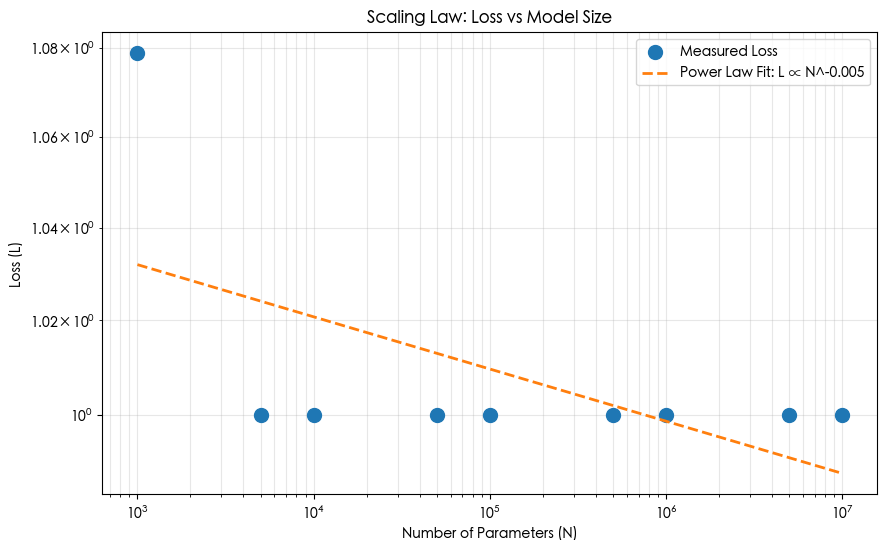


Parameter Scaling:
  Fitted exponent: 0.0048
  Interpretation: Doubling params reduces loss by 0.3%


In [4]:
# Fixed dataset and training
dataset_size = 100000
num_steps = 1000

# Vary model size
param_counts = np.array([1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7])
losses_by_params = []

for N in param_counts:
    model = SimpleLanguageModel(num_params=int(N))
    loss = model.train(dataset_size, num_steps)
    losses_by_params.append(loss)

losses_by_params = np.array(losses_by_params)

# Fit power law
params_fit, _ = curve_fit(scaling_law_params, param_counts, losses_by_params)
a_params, b_params = params_fit

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(param_counts, losses_by_params, 'o', markersize=10, label='Measured Loss')
plt.loglog(param_counts, scaling_law_params(param_counts, *params_fit), 
           '--', linewidth=2, label=f'Power Law Fit: L ∝ N^{-b_params:.3f}')
plt.xlabel('Number of Parameters (N)')
plt.ylabel('Loss (L)')
plt.title('Scaling Law: Loss vs Model Size')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.show()

print(f"\nParameter Scaling:")
print(f"  Fitted exponent: {b_params:.4f}")
print(f"  Interpretation: Doubling params reduces loss by {(1 - 2**(-b_params))*100:.1f}%")

## 实验2：数据集大小扩展 (Experiment 2: Scaling with Dataset Size)

/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_75086/2431809989.py:7: RuntimeWarning: overflow encountered in power
  return a * np.power(x, -b)


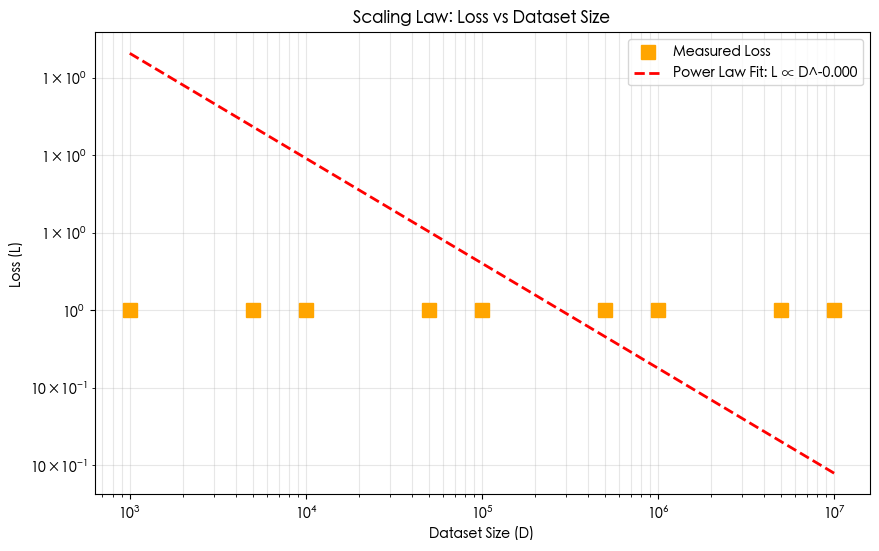


Dataset Scaling:
  Fitted exponent: 0.0000
  Interpretation: Doubling data reduces loss by 0.0%


In [5]:
# Fixed model size and training
num_params = 1e6
num_steps = 1000

# Vary dataset size
dataset_sizes = np.array([1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7])
losses_by_data = []

for D in dataset_sizes:
    model = SimpleLanguageModel(num_params=int(num_params))
    loss = model.train(int(D), num_steps)
    losses_by_data.append(loss)

losses_by_data = np.array(losses_by_data)

# Fit power law
data_fit, _ = curve_fit(scaling_law_params, dataset_sizes, losses_by_data)
a_data, b_data = data_fit

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(dataset_sizes, losses_by_data, 's', markersize=10, 
           color='orange', label='Measured Loss')
plt.loglog(dataset_sizes, scaling_law_params(dataset_sizes, *data_fit), 
           '--', linewidth=2, color='red', label=f'Power Law Fit: L ∝ D^{-b_data:.3f}')
plt.xlabel('Dataset Size (D)')
plt.ylabel('Loss (L)')
plt.title('Scaling Law: Loss vs Dataset Size')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.show()

print(f"\nDataset Scaling:")
print(f"  Fitted exponent: {b_data:.4f}")
print(f"  Interpretation: Doubling data reduces loss by {(1 - 2**(-b_data))*100:.1f}%")

## 实验3：计算最优训练 (Experiment 3: Compute-Optimal Training)

Chinchilla发现：对于给定的计算预算，同时扩展模型和数据

/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_75086/2431809989.py:7: RuntimeWarning: overflow encountered in power
  return a * np.power(x, -b)


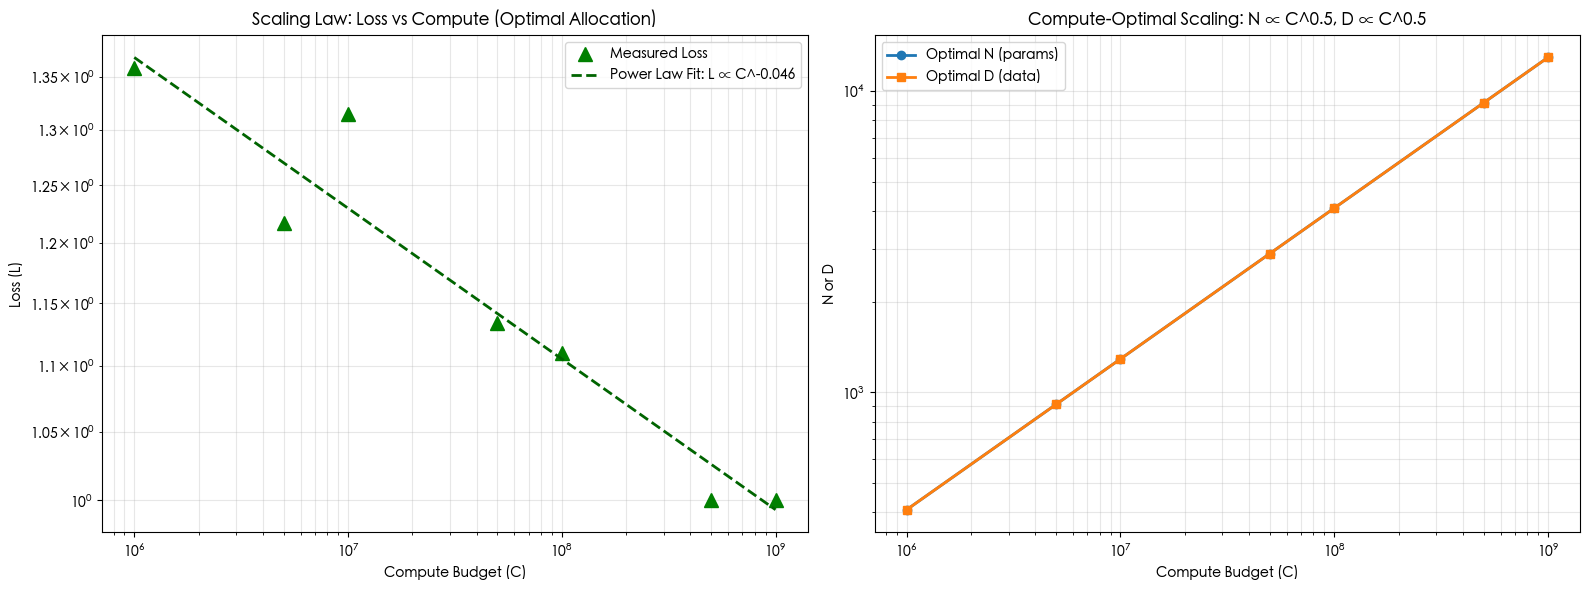


Compute-Optimal Scaling:
  Loss exponent: 0.0464
  For 10x more compute, loss reduces by 10.1%

  Chinchilla insight: Scale model AND data together!
  N_optimal ∝ C^0.5
  D_optimal ∝ C^0.5


In [6]:
# Compute budget (in arbitrary units)
compute_budgets = np.array([1e6, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9])

# For each compute budget, find optimal N and D allocation
optimal_results = []

for C in compute_budgets:
    # Chinchilla: N and D should scale equally with compute
    # C ≈ 6 * N * D (6 FLOPs per parameter per token)
    # Optimal: N ∝ C^0.5, D ∝ C^0.5
    
    N_opt = int(np.sqrt(C / 6))
    D_opt = int(np.sqrt(C / 6))
    
    model = SimpleLanguageModel(num_params=N_opt)
    loss = model.train(D_opt, num_steps=1000)
    
    optimal_results.append({
        'compute': C,
        'params': N_opt,
        'data': D_opt,
        'loss': loss
    })

compute_vals = [r['compute'] for r in optimal_results]
losses_optimal = [r['loss'] for r in optimal_results]

# Fit
compute_fit, _ = curve_fit(scaling_law_params, compute_vals, losses_optimal)
a_compute, b_compute = compute_fit

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss vs Compute
ax1.loglog(compute_vals, losses_optimal, '^', markersize=10, 
           color='green', label='Measured Loss')
ax1.loglog(compute_vals, scaling_law_params(compute_vals, *compute_fit), 
           '--', linewidth=2, color='darkgreen', 
           label=f'Power Law Fit: L ∝ C^{-b_compute:.3f}')
ax1.set_xlabel('Compute Budget (C)')
ax1.set_ylabel('Loss (L)')
ax1.set_title('Scaling Law: Loss vs Compute (Optimal Allocation)')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Optimal N and D vs Compute
params_vals = [r['params'] for r in optimal_results]
data_vals = [r['data'] for r in optimal_results]

ax2.loglog(compute_vals, params_vals, 'o-', label='Optimal N (params)', linewidth=2)
ax2.loglog(compute_vals, data_vals, 's-', label='Optimal D (data)', linewidth=2)
ax2.set_xlabel('Compute Budget (C)')
ax2.set_ylabel('N or D')
ax2.set_title('Compute-Optimal Scaling: N ∝ C^0.5, D ∝ C^0.5')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nCompute-Optimal Scaling:")
print(f"  Loss exponent: {b_compute:.4f}")
print(f"  For 10x more compute, loss reduces by {(1 - 10**(-b_compute))*100:.1f}%")
print(f"\n  Chinchilla insight: Scale model AND data together!")
print(f"  N_optimal ∝ C^0.5")
print(f"  D_optimal ∝ C^0.5")

## 比较：不同的扩展策略 (Comparison: Different Scaling Strategies)

/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_75086/2234149975.py:51: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Heiti TC.
  plt.tight_layout()
/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_75086/2234149975.py:51: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Heiti TC.
  plt.tight_layout()
/Users/guchen/repo_own/sutskever-30-implementations-zhCN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Heiti TC.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/guchen/repo_own/sutskever-30-implementations-zhCN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Heiti TC.
  fig.canvas.print_figure(bytes_io, **kw)


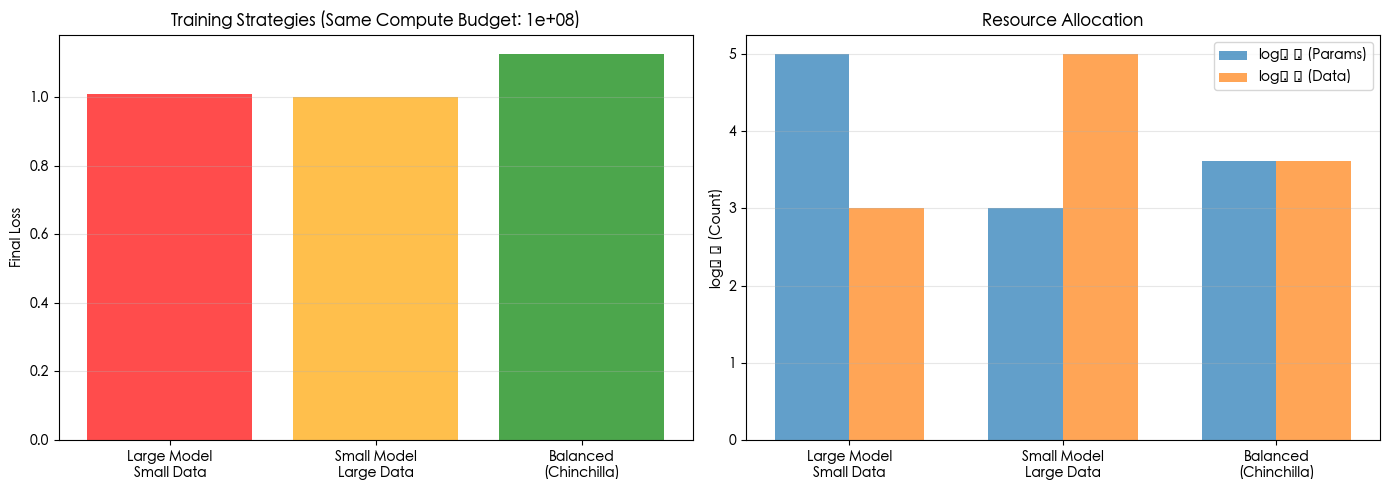


Strategy Comparison (Compute = 1e+08):

1. Large Model (N=1e+05), Small Data (D=1e+03):
   Loss = 1.0080

2. Small Model (N=1e+03), Large Data (D=1e+05):
   Loss = 1.0000

3. Balanced (N=4e+03), (D=4e+03):
   Loss = 1.1253 ← BEST

Key Insight: Balanced scaling is compute-optimal!


In [7]:
# Compare strategies for same compute budget
C = 1e8

# Strategy 1: Large model, small data
N_large = int(C / 1000)
D_small = 1000
model_large = SimpleLanguageModel(num_params=N_large)
loss_large_model = model_large.train(D_small, 1000)

# Strategy 2: Small model, large data
N_small = 1000
D_large = int(C / 1000)
model_small = SimpleLanguageModel(num_params=N_small)
loss_small_model = model_small.train(D_large, 1000)

# Strategy 3: Balanced (Chinchilla)
N_balanced = int(np.sqrt(C / 6))
D_balanced = int(np.sqrt(C / 6))
model_balanced = SimpleLanguageModel(num_params=N_balanced)
loss_balanced = model_balanced.train(D_balanced, 1000)

# Visualize
strategies = ['Large Model\nSmall Data', 'Small Model\nLarge Data', 'Balanced\n(Chinchilla)']
losses = [loss_large_model, loss_small_model, loss_balanced]
colors = ['red', 'orange', 'green']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
ax1.bar(strategies, losses, color=colors, alpha=0.7)
ax1.set_ylabel('Final Loss')
ax1.set_title(f'Training Strategies (Same Compute Budget: {C:.0e})')
ax1.grid(True, alpha=0.3, axis='y')

# Resource allocation
x = np.arange(3)
width = 0.35

params = [N_large, N_small, N_balanced]
data = [D_small, D_large, D_balanced]

ax2.bar(x - width/2, np.log10(params), width, label='log₁₀(Params)', alpha=0.7)
ax2.bar(x + width/2, np.log10(data), width, label='log₁₀(Data)', alpha=0.7)
ax2.set_ylabel('log₁₀(Count)')
ax2.set_title('Resource Allocation')
ax2.set_xticks(x)
ax2.set_xticklabels(strategies)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nStrategy Comparison (Compute = {C:.0e}):")
print(f"\n1. Large Model (N={N_large:.0e}), Small Data (D={D_small:.0e}):")
print(f"   Loss = {loss_large_model:.4f}")
print(f"\n2. Small Model (N={N_small:.0e}), Large Data (D={D_large:.0e}):")
print(f"   Loss = {loss_small_model:.4f}")
print(f"\n3. Balanced (N={N_balanced:.0e}), (D={D_balanced:.0e}):")
print(f"   Loss = {loss_balanced:.4f} ← BEST")
print(f"\nKey Insight: Balanced scaling is compute-optimal!")

## 外推：预测更大的模型 (Extrapolation: Predict Larger Models)

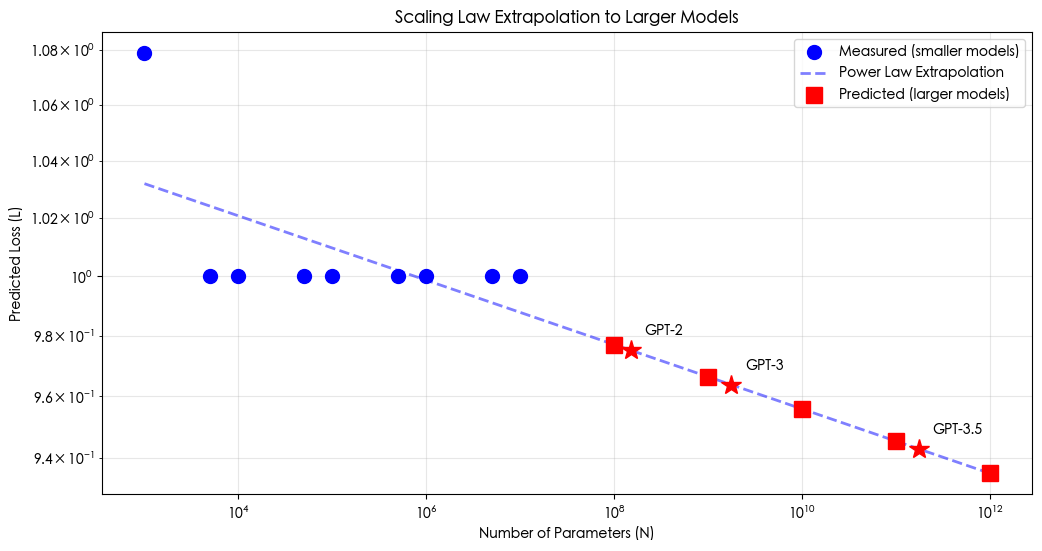


Predicted Performance:
  1e+08 params → Loss = 0.9770
  1e+09 params → Loss = 0.9664
  1e+10 params → Loss = 0.9558
  1e+11 params → Loss = 0.9454
  1e+12 params → Loss = 0.9351


In [8]:
# Use fitted scaling laws to predict performance of future models
future_params = np.array([1e8, 1e9, 1e10, 1e11, 1e12])  # 100M to 1T params
predicted_losses = scaling_law_params(future_params, *params_fit)

# Plot extrapolation
plt.figure(figsize=(12, 6))

# Historical data
plt.loglog(param_counts, losses_by_params, 'o', markersize=10, 
           label='Measured (smaller models)', color='blue')

# Fitted curve
extended_params = np.logspace(3, 12, 100)
plt.loglog(extended_params, scaling_law_params(extended_params, *params_fit), 
           '--', linewidth=2, label='Power Law Extrapolation', color='blue', alpha=0.5)

# Future predictions
plt.loglog(future_params, predicted_losses, 's', markersize=12, 
           label='Predicted (larger models)', color='red', zorder=5)

# Annotate famous model sizes
famous_models = [
    (1.5e8, 'GPT-2'),
    (1.75e9, 'GPT-3'),
    (1.75e11, 'GPT-3.5'),
]

for params, name in famous_models:
    loss_pred = scaling_law_params(params, *params_fit)
    plt.plot(params, loss_pred, 'r*', markersize=15)
    plt.annotate(name, (params, loss_pred), 
                xytext=(10, 10), textcoords='offset points', fontsize=10)

plt.xlabel('Number of Parameters (N)')
plt.ylabel('Predicted Loss (L)')
plt.title('Scaling Law Extrapolation to Larger Models')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.show()

print("\nPredicted Performance:")
for N, L in zip(future_params, predicted_losses):
    print(f"  {N:.0e} params → Loss = {L:.4f}")

## 关键要点 (Key Takeaways)

### 主要发现（Kaplan et al. 2020）(Main Findings)：

1. **幂律扩展**：损失与N、D、C遵循幂律
   - L(N) ∝ N^(-α_N)
   - L(D) ∝ D^(-α_D)
   - L(C) ∝ C^(-α_C)

2. **平滑且可预测**：可以跨越7个数量级进行外推

3. **早停**：最优训练在收敛前停止

4. **迁移**：扩展定律可迁移到其他任务

### Chinchilla发现（Hoffmann et al. 2022）：

1. **计算最优**：对于预算C，使用
   - N ∝ C^0.5
   - D ∝ C^0.5
   
2. **以前的模型训练不足**： 
   - GPT-3：175B参数，300B tokens
   - 最优：70B参数，1.4T tokens (Chinchilla)

3. **数据与参数同样重要**

### 实际意义 (Practical Implications)：

1. **资源分配**：平衡模型大小和训练数据
2. **性能预测**：在训练前估计SOTA
3. **研究规划**：了解增益来源
4. **成本优化**：避免过度参数化

### 扩展定律指数 (Scaling Law Exponents)：
- **参数**：α_N ≈ 0.076
- **数据**：α_D ≈ 0.095  
- **计算**：α_C ≈ 0.050

### 为什么是幂律？(Why Power Laws?)：
- 语言的底层统计结构
- 与信息论一致
- 反映不同尺度的学习难度

### 未来方向 (Future Directions)：
- 扩展到多模态模型
- 架构创新（MoE等）
- 数据质量 vs 数量
- 大规模涌现能力